In [1]:
%pip install transformers accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 86.4 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 314.1/314.1 kB 308.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 419.0/419.0 kB 312.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 196.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 258.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 774.6/774.6 kB 328.5 MB/s eta 0:00:00

[notice] A new release of pip available: 22.2.2 -> 24.1.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import torch, time
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn import manifold
from transformers import AutoModelForCausalLM, AutoTokenizer

In [3]:
model_path = "ibm-granite/granite-3b-code-base"
device = "cpu"

In [4]:
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForCausalLM.from_pretrained(model_path, device_map=device)
model.eval()

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(49152, 2560, padding_idx=0)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear(in_features=2560, out_features=2560, bias=True)
          (k_proj): Linear(in_features=2560, out_features=2560, bias=True)
          (v_proj): Linear(in_features=2560, out_features=2560, bias=True)
          (o_proj): Linear(in_features=2560, out_features=2560, bias=True)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=2560, out_features=10240, bias=True)
          (up_proj): Linear(in_features=2560, out_features=10240, bias=True)
          (down_proj): Linear(in_features=10240, out_features=2560, bias=True)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
    )
    (norm): LlamaRMSNorm()
  )
  (l

what about this variation?

https://stackoverflow.com/questions/76051807/automodelforcausallm-for-extracting-text-embeddings

In [5]:
def model_embeddings(prompts, model, tokenizer):
    embeddings = []
    for p in prompts:
        input_text = str(p)

        input_tokens = tokenizer(input_text, return_tensors="pt")
        for i in input_tokens:
            input_tokens[i] = input_tokens[i].to(device)

        #print(f"{input_tokens['input_ids'].shape}")

        o = model.generate(**input_tokens,
                           max_new_tokens=1,
                           return_dict_in_generate=True,
                           output_scores=False,
                           output_hidden_states=True)

        # last hidden layer, for each of the input tokens
        lh = o.hidden_states[0][-1][0]
        # normalize each token embedding to unit length
        lh = torch.nn.functional.normalize(lh, dim=1)
        # number of input tokens
        nt = len(lh)
        # mean of the embedding vectors over the input tokens
        # some community recommend weighted average here
        lhavg = torch.sum(lh, 0) / nt
        #print(f"last: {lhavg.shape} {lhavg}")
        embeddings.append(lhavg.numpy())
    # return the list of embeddings as a tensor
    return torch.tensor(np.array(embeddings))

In [6]:
benchmark = pd.read_parquet("/opt/app-root/src/mmlu-all-dev.parquet")

In [7]:
embeddings = model_embeddings(benchmark["question"], model, tokenizer)

In [8]:
insurance = [
    "when does my policy expire?",
    "does my home insurance cover flooding?",
    "where can I find my premimum for auto insurance?",
    "how do I add a car to my auto policy?",
    "can I bundle my auto and home insurance policies?",
    "what is the deductable on my umbrella policy?",
    "how can I find the contact info for my agent?",
]

In [9]:
embeddings_ins = model_embeddings(insurance, model, tokenizer)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


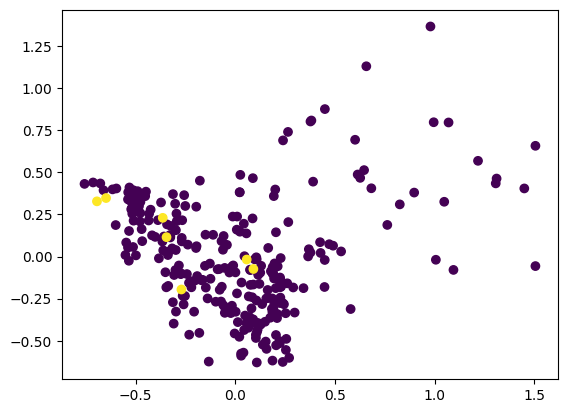

In [10]:
xform = manifold.Isomap(n_components = 2)
e2d = xform.fit_transform(torch.cat((embeddings, embeddings_ins)))

x, y = e2d.transpose()
colors = ([1] * len(embeddings)) + ([2] * len(embeddings_ins))
fig, ax = plt.subplots()
ax.scatter(x,y, c = colors)

stress = 851.334463331819


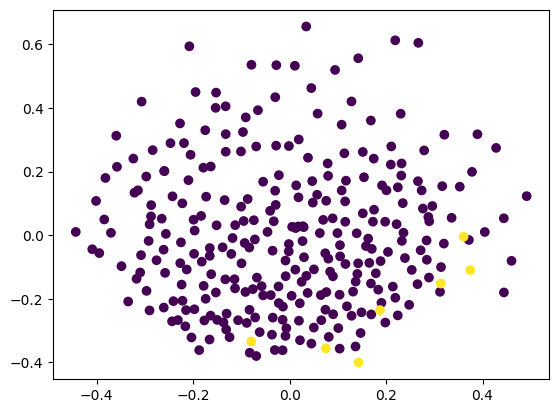

In [16]:
xform = manifold.MDS(n_components = 2, normalized_stress='auto', n_init=100, max_iter=5000, eps=1e-4)
e2d = xform.fit_transform(torch.cat((embeddings, embeddings_ins)))
print(f"stress = {xform.stress_}")

x, y = e2d.transpose()
colors = ([1] * len(embeddings)) + ([2] * len(embeddings_ins))
fig, ax = plt.subplots()
ax.scatter(x,y, c = colors)